In [56]:
from flask import Flask
from flask import request
import werkzeug
import cv2
from PIL import Image
import mediapipe as mp
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [57]:
class Results:
    
    cols = ["x","y","z","vis"]
    #TRAGULAR DATA
    trag_cols = ["x","y","z","vis"]
    trag_left_rows = ["left_ear","left_index"]
    trag_right_rows = ["right_ear","right_index"]
    tragular_left_coord = []
    tragular_right_coord = []
    
    #LUMBAR DATA
    lumbar_cols = ["x","y","z","vis"]
    lumbar_rows = ["left_index","right_index"]
    lumbar_neutral_coord = []
    lumbar_left_coord = []
    lumbar_right_coord = []
    
    #INTERMALLEOLAR DATA
    intermalleolar_rows = ["left_ankle","left_heel","left_foot_index",
                          "right_ankle","right_heel","right_foot_index"]
    intermalleolar_coord = []
    
    

In [58]:
#Function used to calculate the relevant tragular coordinates
def mp_pose_tragular(side,file):
    #mp_pose = mp.solutions.pose
    #results = draw_image(file,"tragular")
    
    mp_drawing = mp.solutions.drawing_utils
    mp_drawing_styles = mp.solutions.drawing_styles
    mp_pose = mp.solutions.pose
    pose = mp_pose.Pose(static_image_mode = True,model_complexity = 2, enable_segmentation=True,min_detection_confidence = 0.5)
    image = cv2.imread(file)
    results = pose.process(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))
    mp_drawing.draw_landmarks(
        image,
        results.pose_landmarks,
        mp_pose.POSE_CONNECTIONS,
        landmark_drawing_spec=mp_drawing.DrawingSpec(color=(255,255,255), thickness=5, circle_radius=6),
        connection_drawing_spec=mp_drawing.DrawingSpec(color=(49,125,237),
        thickness=5, circle_radius=5))
    mp_drawing.plot_landmarks(results.pose_world_landmarks, mp_pose.POSE_CONNECTIONS)
    cv2.imwrite("tragular.png",image)
    
    if(side == 0):
        coordinate_list = [[results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_EAR].x,
                                        results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_EAR].y,
                                        results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_EAR].z,
                                        results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_EAR].visibility],
                                       [results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_INDEX].x,
                                       results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_INDEX].y,
                                       results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_INDEX].z,
                                       results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_INDEX].visibility]]
        Results.tragular_left_coord = pd.DataFrame(coordinate_list,columns=Results.trag_cols)
        Results.tragular_left_coord.index = Results.trag_left_rows
        print(Results.tragular_left_coord)
    else:
        coordinate_list = [[results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_EAR].x,
                                        results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_EAR].y,
                                        results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_EAR].z,
                                        results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_EAR].visibility],
                                       [results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_INDEX].x,
                                       results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_INDEX].y,
                                       results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_INDEX].z,
                                       results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_INDEX].visibility]]
        Results.tragular_right_coord = pd.DataFrame(coordinate_list,columns=Results.trag_cols)
        Results.tragular_right_coord.index = Results.trag_right_rows
        print(Results.tragular_right_coord)
    

In [59]:
#Function used to calculate relevant lumbar coordinates
def mp_pose_lumbar(side,file):
    
    mp_drawing = mp.solutions.drawing_utils
    mp_drawing_styles = mp.solutions.drawing_styles
    mp_pose = mp.solutions.pose
    pose = mp_pose.Pose(static_image_mode = True,model_complexity = 2, enable_segmentation=True,min_detection_confidence = 0.5)
    image = cv2.imread(file)
    results = pose.process(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))
    mp_drawing.draw_landmarks(
        image,
        results.pose_landmarks,
        mp_pose.POSE_CONNECTIONS,
        landmark_drawing_spec=mp_drawing.DrawingSpec(color=(255,255,255), thickness=5, circle_radius=6),
        connection_drawing_spec=mp_drawing.DrawingSpec(color=(49,125,237),
        thickness=5, circle_radius=5))
    mp_drawing.plot_landmarks(results.pose_world_landmarks, mp_pose.POSE_CONNECTIONS)
    cv2.imwrite("lumbar.png",image)

    coordinate_list = [[results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_INDEX].x,
                            results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_INDEX].y,
                            results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_INDEX].z,
                            results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_INDEX].visibility],
                           [results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_INDEX].x,
                            results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_INDEX].y,
                            results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_INDEX].z,
                            results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_INDEX].visibility]]
    
    if(side == -1):
        Results.lumbar_left_coord = pd.DataFrame(coordinate_list,columns=Results.lumbar_cols)
        Results.lumbar_left_coord.index = Results.lumbar_rows
        print(Results.lumbar_left_coord)
    elif(side == 0):
        Results.lumbar_neutral_coord = pd.DataFrame(coordinate_list,columns=Results.lumbar_cols)
        Results.lumbar_neutral_coord.index = Results.lumbar_rows
        print(Results.lumbar_neutral_coord)
    else:
        Results.lumbar_right_coord = pd.DataFrame(coordinate_list,columns=Results.lumbar_cols)
        Results.lumbar_right_coord.index = Results.lumbar_rows
        print(Results.lumbar_right_coord)
    
    
    

In [60]:
def mp_pose_intermalleolar(file):
    mp_drawing = mp.solutions.drawing_utils
    mp_drawing_styles = mp.solutions.drawing_styles
    mp_pose = mp.solutions.pose
    pose = mp_pose.Pose(static_image_mode = True,model_complexity = 2, enable_segmentation=True,min_detection_confidence = 0.5)
    image = cv2.imread(file)
    results = pose.process(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))
    mp_drawing.draw_landmarks(
        image,
        results.pose_landmarks,
        mp_pose.POSE_CONNECTIONS,
        landmark_drawing_spec=mp_drawing.DrawingSpec(color=(255,255,255), thickness=5, circle_radius=6),
        connection_drawing_spec=mp_drawing.DrawingSpec(color=(49,125,237),
        thickness=5, circle_radius=5))
    mp_drawing.plot_landmarks(results.pose_world_landmarks, mp_pose.POSE_CONNECTIONS)
    cv2.imwrite("intermalleolar.png",image)
    
    coordinate_list = [[results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_ANKLE].x,
                            results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_ANKLE].y,
                            results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_ANKLE].z,
                            results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_ANKLE].visibility],
                            [results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_HEEL].x,
                            results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_HEEL].y,
                            results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_HEEL].z,
                            results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_HEEL].visibility],
                            [results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_FOOT_INDEX].x,
                            results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_FOOT_INDEX].y,
                            results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_FOOT_INDEX].z,
                            results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_FOOT_INDEX].visibility],
                            [results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_ANKLE].x,
                            results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_ANKLE].y,
                            results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_ANKLE].z,
                            results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_ANKLE].visibility],
                            [results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_HEEL].x,
                            results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_HEEL].y,
                            results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_HEEL].z,
                            results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_HEEL].visibility],
                            [results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_FOOT_INDEX].x,
                            results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_FOOT_INDEX].y,
                            results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_FOOT_INDEX].z,
                            results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_FOOT_INDEX].visibility]]
    Results.intermalleolar_coord = pd.DataFrame(coordinate_list,columns=Results.cols)
    Results.intermalleolar_coord.index = Results.intermalleolar_rows
    

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on all addresses.
 * Running on http://138.38.166.67:5000/ (Press CTRL+C to quit)
138.38.214.43 - - [13/Jul/2022 17:55:13] "POST /debug HTTP/1.1" 200 -


TRAGULAR CONNECTED

Received image file name: right_tragular.png


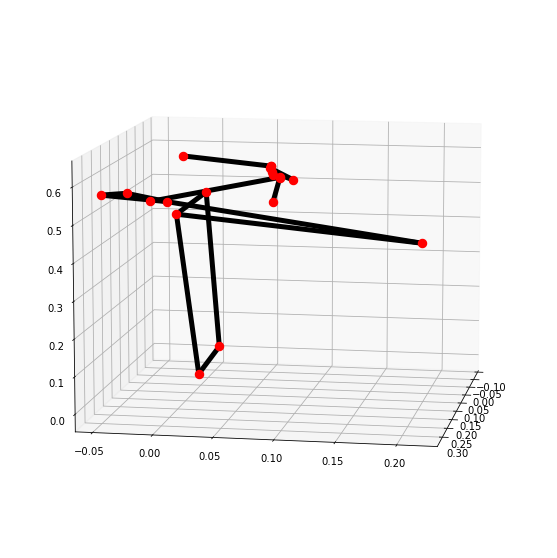

138.38.214.43 - - [13/Jul/2022 17:55:23] "POST /tragularRight HTTP/1.1" 200 -


                    x         y         z       vis
right_ear    0.443995  0.410161 -0.589134  0.998323
right_index  0.431772  0.478941 -1.157711  0.569356

Successful upload

Received image file name: left_tragular.png


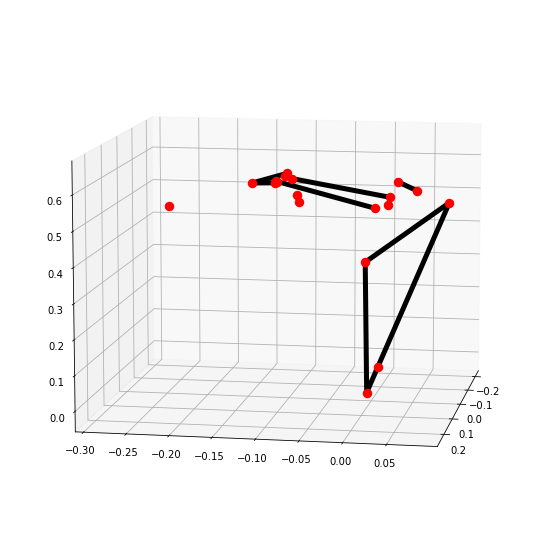

138.38.214.43 - - [13/Jul/2022 17:55:48] "POST /tragularLeft HTTP/1.1" 200 -


                   x         y         z       vis
left_ear    0.550540  0.469245 -0.638753  0.999796
left_index  0.575802  0.544783 -0.387935  0.704604

Successful upload


138.38.214.43 - - [13/Jul/2022 17:55:58] "POST /debug HTTP/1.1" 200 -


LUMBAR CONNECTED

Received image file name: neutral_lumbar.jpg


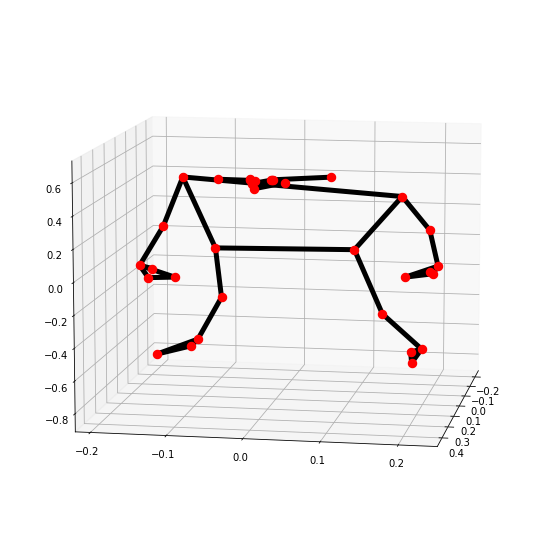

138.38.214.43 - - [13/Jul/2022 17:56:09] "POST /lumbarNeutral HTTP/1.1" 200 -


                    x         y         z       vis
left_index   0.563594  0.684788 -0.427838  0.982347
right_index  0.381452  0.689355 -0.517586  0.980087

Successful upload

Received image file name: Right_lumbar.jpg


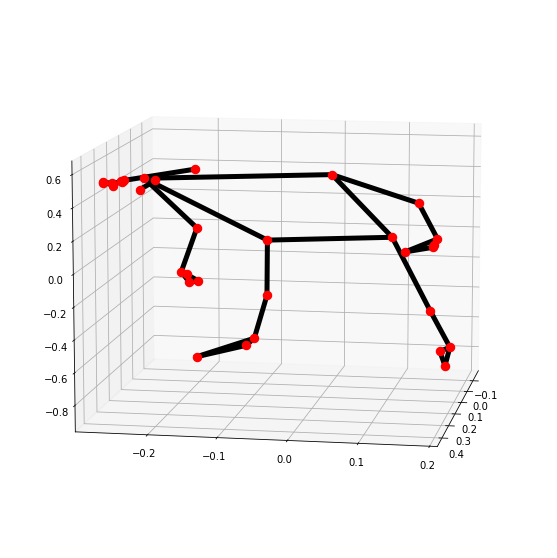

138.38.214.43 - - [13/Jul/2022 17:56:25] "POST /lumbarRight HTTP/1.1" 200 -


                    x         y         z       vis
left_index   0.488932  0.648025 -0.535615  0.990628
right_index  0.329570  0.737448 -0.451235  0.966922

Successful upload

Received image file name: left_lumbar.jpg


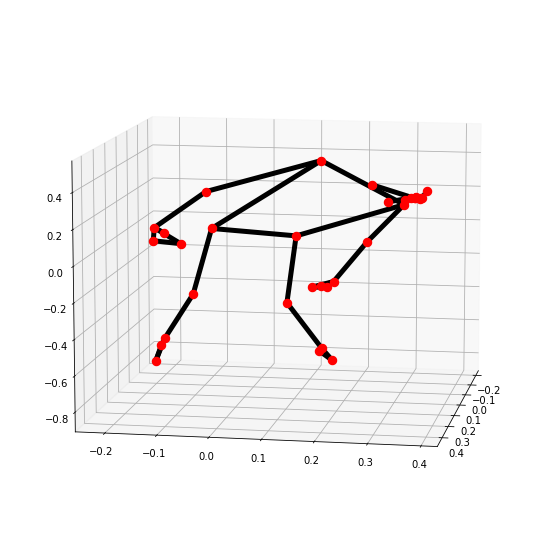

138.38.214.43 - - [13/Jul/2022 17:56:41] "POST /lumbarLeft HTTP/1.1" 200 -


                    x         y         z       vis
left_index   0.558241  0.690651 -0.378419  0.986973
right_index  0.396062  0.558517 -0.574652  0.983738

Successful upload


138.38.214.43 - - [13/Jul/2022 17:56:50] "POST /debug HTTP/1.1" 200 -


INTERMALLEOLAR CONNECTED

Received image file name: intermalleolar.jpg


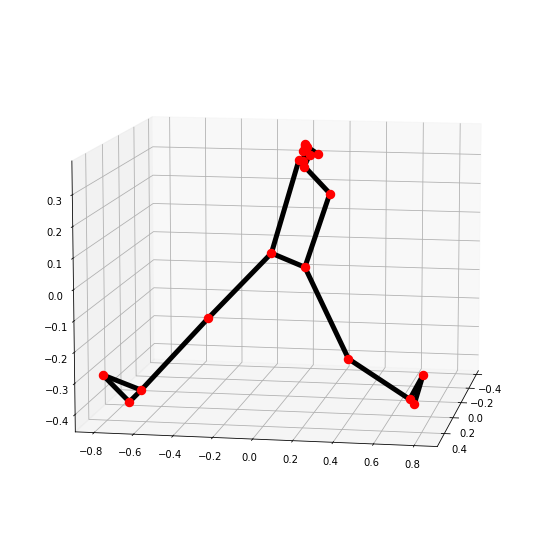

138.38.214.43 - - [13/Jul/2022 17:57:10] "POST /intermalleolar HTTP/1.1" 200 -



Successful upload


In [ ]:
app = Flask(__name__)

@app.route("/")
def showHomePage():
    return "This is home page"

@app.route("/debug",methods=["POST"])
def debug():
    text = request.form["sample"]
    print(text)
    return "received"

@app.route("/tragularLeft",methods=["POST"])
def tragularLeft():
    imageFile = request.files['leftTragular']
    filename = werkzeug.utils.secure_filename(imageFile.filename)
    print("\nReceived image file name: "+imageFile.filename)
    imageFile.save(filename)
    mp_pose_tragular(0,filename)
    print("\nSuccessful upload")
    return "Image uploaded successfully"

@app.route("/tragularRight",methods=["POST"])
def tragularRight():
    imageFile = request.files['rightTragular']
    filename = werkzeug.utils.secure_filename(imageFile.filename)
    print("\nReceived image file name: "+imageFile.filename)
    imageFile.save(filename)
    mp_pose_tragular(1,filename)
    print("\nSuccessful upload")
    return "Image uploaded successfully"

@app.route("/lumbarLeft",methods=["POST"])
def lumbarLeft():
    imageFile = request.files['leftLumbar']
    filename = werkzeug.utils.secure_filename(imageFile.filename)
    print("\nReceived image file name: "+imageFile.filename)
    imageFile.save(filename)
    mp_pose_lumbar(-1,filename)
    print("\nSuccessful upload")
    return "Image uploaded successfully"

@app.route("/lumbarNeutral",methods=["POST"])
def lumbarNeutral():
    imageFile = request.files['neutralLumbar']
    filename = werkzeug.utils.secure_filename(imageFile.filename)
    print("\nReceived image file name: "+imageFile.filename)
    imageFile.save(filename)
    mp_pose_lumbar(0,filename)
    print("\nSuccessful upload")
    return "Image uploaded successfully"

@app.route("/lumbarRight",methods=["POST"])
def lumbarRight():
    imageFile = request.files['rightLumbar']
    filename = werkzeug.utils.secure_filename(imageFile.filename)
    print("\nReceived image file name: "+imageFile.filename)
    imageFile.save(filename)
    mp_pose_lumbar(1,filename)
    print("\nSuccessful upload")
    return "Image uploaded successfully"

@app.route("/intermalleolar",methods=["POST"])
def intermalleolar():
    imageFile = request.files['intermalleolar']
    filename = werkzeug.utils.secure_filename(imageFile.filename)
    print("\nReceived image file name: "+imageFile.filename)
    imageFile.save(filename)
    mp_pose_intermalleolar(filename)
    print("\nSuccessful upload")
    return "Image uploaded successfully"

if __name__ == "__main__":
    app.run(host="0.0.0.0")